In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler

import os
import h5py
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "1,2"
from time import time

import FrEIA.framework  as Ff
import FrEIA.modules as Fm

import losses
import monitoring


In [2]:
filename_out    = 'output/inn.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 1.0e-4
#Batch size
batch_size      = 128
# Total number of epochs to train for
n_epochs        = 50

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 0
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x_class     = 3
ndim_pad_x_class = 397
ndim_x_features     = 7
ndim_pad_x_features = 593

ndim_y     = 512
ndim_z     = 10
ndim_pad_zy = 478 

# Overwrite or import data loaders here.
# See dkfz_train.py for reference.
#from my_loaders import train_loader, test_loader

train_loader, test_loader = None, None

assert (ndim_x_class + ndim_x_features + ndim_pad_x_class+ ndim_pad_x_features 
        == ndim_y + ndim_z + ndim_pad_zy), "Dimensions don't match up"

############
#  Losses  #
############

train_forward_mmd    = True
train_backward_mmd   = True
train_reconstruction = True
train_max_likelihood = False

lambd_fit_forw         = 10.
lambd_mmd_forw         = 50.
lambd_reconstruct      = 1.
lambd_mmd_back_class   = 100.
lambd_mmd_back_feature = 50.
lambd_max_likelihood   = 1.

# Both for fitting, and for the reconstruction, perturb y with Gaussian 
# noise of this sigma
add_y_noise     = 5e-2 # think of smth smart here
# For reconstruction, perturb z 
add_z_noise     = 2e-2
# In all cases, perturb the zero padding
add_pad_noise   = 1e-2

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 4

mmd_forw_kernels = [(0.2, 2), (1.5, 2), (3.0, 2)]
mmd_back_kernels = [(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 5
#
exponent_clamping = 3.0
#
hidden_layer_sizes = 64
#
use_permutation = True
#
verbose_construction = False

In [3]:
def read_data(path):
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path,f))]
    labels = torch.zeros(len(files), ndim_y, dtype = torch.float32)
    inputs = torch.zeros(len(files), ndim_x_class+ndim_x_features, dtype = torch.float32)
    input_keys = ['shape', 'radius', 'radius_pd','length', 'length_pd',  'volfraction']
    for i,f in enumerate(files):
        with  h5py.File(os.path.join(path,f),'r') as file:
            print(file, end = '\r')
            labels[i,:] = torch.from_numpy(file['entry/I'][()].flatten())#I_noisy
            for i_k, key in enumerate(input_keys):
                try:
                    if key == 'shape':
                        shape = file['properties'][key][()].decode("utf-8")
                        if shape == 'sphere':
                            inputs[i, i_k:i_k+3] = torch.tensor([1,0,0]) 
                            #conditions[i, i+k]
                        elif shape == 'hardsphere':
                            inputs[i, i_k:i_k+3] = torch.tensor([0,1,0])
                        else:
                            inputs[i, i_k:i_k+3] = torch.tensor([0,0,1])
                    elif key =='radius':
                        if shape == 'sphere':
                            inputs[i, i_k+2:i_k+5] = torch.tensor([file['properties'][key][()],0,0]) 
                        elif shape == 'hardsphere':
                            inputs[i, i_k+2:i_k+5] = torch.tensor([0,file['properties'][key][()],0])
                        else:
                            inputs[i, i_k+2:i_k+5] = torch.tensor([0,0,file['properties'][key][()]])
                    else:
                        inputs[i, i_k+4] = file['properties'][key][()]
                except KeyError:
                    # spheres don't have all of the properties a cylinder does
                    pass
    return inputs, labels
            

In [4]:
inputs,labels = read_data('/home/slaskina/simulations')


In [5]:

# Creating data indices for training and validation splits:
dataset_size = len(labels)
indices = list(range(dataset_size))
test_size = 0.1
val_size = 0.2
test_split = int(np.floor(test_size * dataset_size))
val_split = int(np.floor(val_size * dataset_size))
np.random.seed(1234)
np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[:dataset_size-test_split-val_split], indices[dataset_size-test_split-val_split:dataset_size-test_split], indices[dataset_size-test_split:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [6]:
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(inputs, labels), batch_size=batch_size, drop_last=True, sampler = val_sampler)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(inputs, labels), batch_size=batch_size, drop_last=True, sampler = train_sampler)

In [7]:

input1 = Ff.InputNode(ndim_x_class + ndim_pad_x_class, name='input_class')
input2 = Ff.InputNode(ndim_x_features + ndim_pad_x_features, name='input_features')

nodes = [input1]
for i in range(N_blocks):
    nodes.append(Ff.Node([nodes[-1].out0],Fm.IResNetLayer, {'internal_size':hidden_layer_sizes, 
                                                'n_internal_layers':4, 
                                                'jacobian_iterations':12,
                                                'hutchinson_samples':1, 
                                                'fixed_point_iterations':50,
                                                'lipschitz_iterations':10,
                                                'lipschitz_batchsize':10,
                                                'spectral_norm_max':0.8,
                                                }, name='ires'+str(i)))

    nodes.append(Ff.Node([nodes[-1].out0], Fm.PermuteRandom, {'seed':i}, name='class_permute_'+str(i)))
nodes.append(input2)
nodes.append(Ff.Node([nodes[-2].out0, nodes[-1].out0], Fm.Concat, {}, name='Concat'))

for i in range(N_blocks):
    nodes.append(Ff.Node([nodes[-1].out0],Fm.IResNetLayer, {'internal_size':hidden_layer_sizes, 
                                                'n_internal_layers':3, 
                                                'jacobian_iterations':12,
                                                'hutchinson_samples':1, 
                                                'fixed_point_iterations':50,
                                                'lipschitz_iterations':10,
                                                'lipschitz_batchsize':10,
                                                'spectral_norm_max':0.8,
                                                }, name='ires_concat_'+str(i)))
    nodes.append(Ff.Node([nodes[-1].out0], Fm.PermuteRandom, {'seed':N_blocks+i}, name='class_permute_'+str(N_blocks+i)))
nodes.append(Ff.OutputNode([nodes[-1].out0], name='output'))
model = Ff.GraphINN(nodes, verbose=verbose_construction)
      
model.to(device)


GraphINN(
  (module_list): ModuleList(
    (0): IResNetLayer(
      (residual): Sequential(
        (0): Linear(in_features=400, out_features=64, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): ELU(alpha=1.0)
        (4): Linear(in_features=64, out_features=64, bias=True)
        (5): ELU(alpha=1.0)
        (6): Linear(in_features=64, out_features=64, bias=True)
        (7): ELU(alpha=1.0)
        (8): Linear(in_features=64, out_features=64, bias=True)
        (9): ELU(alpha=1.0)
        (10): Linear(in_features=64, out_features=400, bias=True)
      )
    )
    (1): PermuteRandom()
    (2): IResNetLayer(
      (residual): Sequential(
        (0): Linear(in_features=400, out_features=64, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): ELU(alpha=1.0)
        (4): Linear(in_features=64, out_features=64, bias=True)
        (5): ELU(alpha=1.0)
        (6):

In [8]:

params_trainable = list(filter(lambda p: p.requires_grad, model.parameters()))
for p in params_trainable:
    p.data = init_scale * torch.randn(p.data.shape).to(device)

gamma = (final_decay)**(1./n_epochs)
optim = torch.optim.Adam(params_trainable, lr=lr_init, betas=adam_betas, eps=1e-6, weight_decay=l2_weight_reg)
weight_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=gamma)

def optim_step():
    #for p in params_trainable:
        #print(torch.mean(torch.abs(p.grad.data)).item())
    optim.step()
    optim.zero_grad()

def scheduler_step():
    #weight_scheduler.step()
    pass

def save(name):
    torch.save({'opt':optim.state_dict(),
                'net':model.state_dict()}, name)

def load(name):
    state_dicts = torch.load(name)
    model.load_state_dict(state_dicts['net'])
    try:
        optim.load_state_dict(state_dicts['opt'])
    except ValueError:
        print('Cannot load optimizer for some reason or other')

In [9]:

def noise_batch(ndim):
    return torch.randn(batch_size, ndim).to(device)

def loss_max_likelihood(out, y):
    jac = jacobian(run_forward=False)

    neg_log_likeli = ( 0.5 / y_uncertainty_sigma**2 * torch.sum((out[:, -ndim_y:]       - y[:, -ndim_y:])**2, 1)
                     + 0.5 / zeros_noise_scale**2   * torch.sum((out[:, ndim_z:-ndim_y] - y[:, ndim_z:-ndim_y])**2, 1)
                     + 0.5 * torch.sum(out[:, :ndim_z]**2, 1)
                     - jac)

    return lambd_max_likelihood * torch.mean(neg_log_likeli)

def loss_forward_mmd(out, y):
    # Shorten output, and remove gradients wrt y, for latent loss
    # [z,y] only
    output_block_grad = torch.cat((out[:, :ndim_z],
                                   out[:, -ndim_y:].data), dim=1) 
    y_short = torch.cat((y[:, :ndim_z], y[:, -ndim_y:]), dim=1)

    l_forw_fit = lambd_fit_forw * losses.l2_fit(out[:, ndim_z:], y[:, ndim_z:])
    l_forw_mmd = lambd_mmd_forw  * torch.mean(losses.forward_mmd(output_block_grad, y_short))

    return l_forw_fit, l_forw_mmd

def loss_backward_mmd(x_class, x_features, y):
    [x_samples_class, x_samples_features], x_samples_jac = model(y, rev=True, jac = False) 
    MMD_class = losses.backward_mmd(x_class, x_samples_class) 
    MMD_features = losses.backward_mmd(x_features, x_samples_features)
    if mmd_back_weighted:
        MMD_class *= torch.exp(- 0.5 / y_uncertainty_sigma**2 * losses.l2_dist_matrix(y, y))
        MMD_features *= torch.exp(- 0.5 / y_uncertainty_sigma**2 * losses.l2_dist_matrix(y, y))
    return lambd_mmd_back_class * torch.mean(MMD_class)+lambd_mmd_back_feature * torch.mean(MMD_features)


def loss_reconstruction(out_y, x_class, x_features):
    cat_inputs = [out_y[:, :ndim_z] + add_z_noise * noise_batch(ndim_z)] # list with 1 tensor
    
    if ndim_pad_zy:
        cat_inputs.append(out_y[:, ndim_z:-ndim_y] + add_pad_noise * noise_batch(ndim_pad_zy)) # list with 2 tensor
    cat_inputs.append(out_y[:, -ndim_y:] + add_y_noise * noise_batch(ndim_y)) # list with 3 tensors
    [x_reconstructed_class, x_reconstructed_features], x_reconstructed_jac = model(torch.cat(cat_inputs, 1), rev=True, jac = False) # concatenate list elements along axis 1
    return lambd_reconstruct * (losses.l2_fit(x_reconstructed_class[:, :ndim_pad_x_class], x_class[:,:ndim_pad_x_class]) + losses.l2_fit(x_reconstructed_features[:,:ndim_pad_x_features], x_features[:,:ndim_pad_x_features]) )# needs fix

def train_epoch(i_epoch, test=False):
    if not test:
        model.train()
        loader = train_loader

    if test:
        model.eval()
        loader = test_loader
        nograd = torch.no_grad()
        nograd.__enter__()


    batch_idx = 0
    loss_history = []

    for x, y in loader:

        if batch_idx > n_its_per_epoch:
            break
        batch_losses = []

        batch_idx += 1

        x, y = x.to(device), y.to(device)

        if add_y_noise > 0:
            y += add_y_noise * noise_batch(ndim_y)
        if ndim_pad_x_class:
            x_class = torch.cat((x[:,:3], add_pad_noise * noise_batch(ndim_pad_x_class)), dim=1)
        
        if ndim_pad_x_features:
            x_features = torch.cat((x[:,3:], add_pad_noise * noise_batch(ndim_pad_x_features)), dim=1)
        if ndim_pad_zy:
            y = torch.cat((add_pad_noise * noise_batch(ndim_pad_zy), y), dim=1)
        y = torch.cat((noise_batch(ndim_z), y), dim=1)

        out_y, out_y_jac = model([x_class,x_features], jac  = False)
        # tuple with output[0] and jacobian[1]
        if train_max_likelihood:
            batch_losses.append(loss_max_likelihood(out_y, y))

        if train_forward_mmd:
            batch_losses.extend(loss_forward_mmd(out_y, y))

        if train_backward_mmd:
            batch_losses.append(loss_backward_mmd(x_class,x_features, y))

        if train_reconstruction:
            batch_losses.append(loss_reconstruction(out_y.data, x_class, x_features))

        l_total = sum(batch_losses)
        loss_history.append([l.item() for l in batch_losses]) # lisr of lists: list for each batch

        if not test:
            l_total.backward()
            optim_step()

    if test:
        monitoring.show_hist(out_y[:, :ndim_z])
        monitoring.show_cov(out_y[:, :ndim_z])
        if test_time_functions:
            out_x_class, out_x_features, out_x_jac = model(y, rev=True, jac = False) 
            for f in test_time_functions:
                f(out_x_class, out_x_features, out_y, x_class,x_features, y)

        nograd.__exit__(None, None, None)
    return np.mean(loss_history, axis=0)

def train():
    monitoring.restart()

    try:
        monitoring.print_config()
        t_start = time()
        for i_epoch in range(-pre_low_lr, n_epochs):

            if i_epoch < 0:
                for param_group in optim.param_groups:
                    param_group['lr'] = lr_init * 1e-1

            train_losses = train_epoch(i_epoch) # mean over batches
            test_losses  = train_epoch(i_epoch, test=True)
            t = np.concatenate([train_losses, test_losses])
            monitoring.show_loss(t)
            scheduler_step() 

    except:
        save(filename_out + '_ABORT')
        raise

    finally:
        print("\n\nTraining took %f minutes\n\n" % ((time()-t_start)/60.))
        save(filename_out)



In [10]:
train()


Config options:

  N_blocks                 	5
  adam_betas               	(0.9, 0.95)
  add_pad_noise            	0.01
  add_y_noise              	0.05
  add_z_noise              	0.02
  batch_size               	256
  device                   	cuda
  exponent_clamping        	3.0
  filename_in              	
  filename_out             	output/my_inn.pt
  final_decay              	0.02
  hidden_layer_sizes       	16
  init_scale               	0.1
  interactive_visualization	False
  l2_weight_reg            	1e-05
  lambd_fit_forw           	10.0
  lambd_max_likelihood     	1.0
  lambd_mmd_back_class     	500.0
  lambd_mmd_back_feature   	50.0
  lambd_mmd_forw           	50.0
  lambd_reconstruct        	1.0
  lr_init                  	0.001
  mmd_back_kernels         	[(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
  mmd_back_weighted        	True
  mmd_forw_kernels         	[(0.2, 2), (1.5, 2), (3.0, 2)]
  n_epochs                 	25
  n_its_per_epoch          	200
  ndim_pad_x_class         	39

In [11]:
from visualizations import plot_outcomes_identified, describe_false_shapes, describe_positive_shapes, create_table_from_outcome

In [12]:
def make_prediction(labels, model):
    y = torch.cat((add_pad_noise * torch.randn( len(labels), ndim_pad_zy).to('cuda'), labels.to('cuda')), dim=1)
    y = torch.cat((torch.randn( len(labels), ndim_z).to('cuda'), y), dim=1)
    [pred_class, pred_features], _ = model(y, rev = True)  # output of NN without padding
    return np.concatenate((pred_class.cpu().detach()[:,:ndim_x_class], pred_features.cpu().detach()[:, :ndim_x_features]), axis=1)


In [13]:
df_train = create_table_from_outcome(make_prediction(labels[train_indices], model), inputs[train_indices])
df_val = create_table_from_outcome(make_prediction(labels[val_indices],model), inputs[val_indices]) 
df_test = create_table_from_outcome(make_prediction(labels[test_indices], model), inputs[test_indices])

Accuracy is 34.50%
MSE for radius per shape for correctly identified instances as follows: sphere: 0.0127, hardsphere: 0.0171 and cylinder: 0.0137
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 0.0020, hardsphere: 0.0019 and cylinder: 0.0022
MSE for cylinder length for correctly identified instances: 1.3192
MSE for cylinder length polydispersity for correctly identified instances: 0.0034
MSE for cylinder length for correctly identified instances: 0.0125


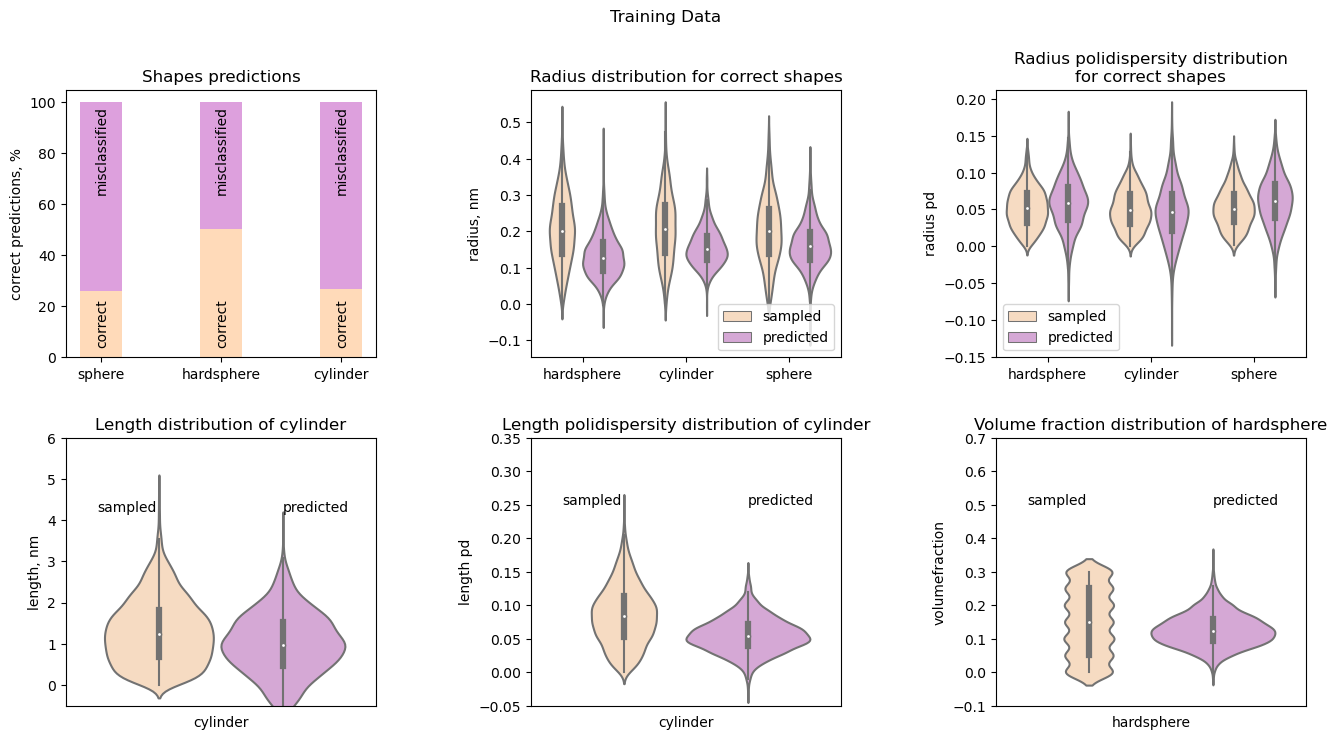

In [14]:
plot_outcomes_identified(df_train, 'Training')

Accuracy is 33.97%
MSE for radius per shape for correctly identified instances as follows: sphere: 0.0169, hardsphere: 0.0159 and cylinder: 0.0143
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 0.0018, hardsphere: 0.0018 and cylinder: 0.0019
MSE for cylinder length for correctly identified instances: 1.1786
MSE for cylinder length polydispersity for correctly identified instances: 0.0033
MSE for cylinder length for correctly identified instances: 0.0139


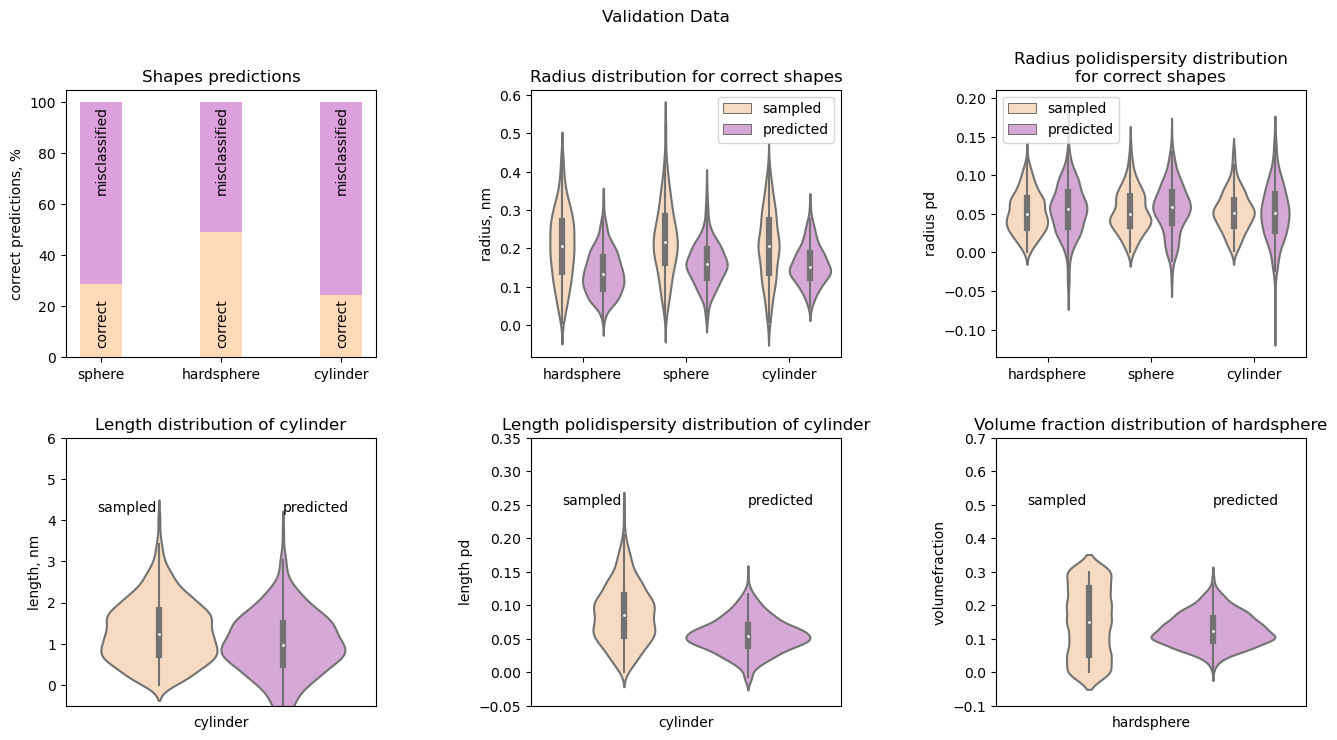

In [15]:
plot_outcomes_identified(df_val, 'Validation')

Accuracy is 32.13%
MSE for radius per shape for correctly identified instances as follows: sphere: 0.0142, hardsphere: 0.0192 and cylinder: 0.0111
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 0.0023, hardsphere: 0.0016 and cylinder: 0.0018
MSE for cylinder length for correctly identified instances: 1.3565
MSE for cylinder length polydispersity for correctly identified instances: 0.0039
MSE for cylinder length for correctly identified instances: 0.0138


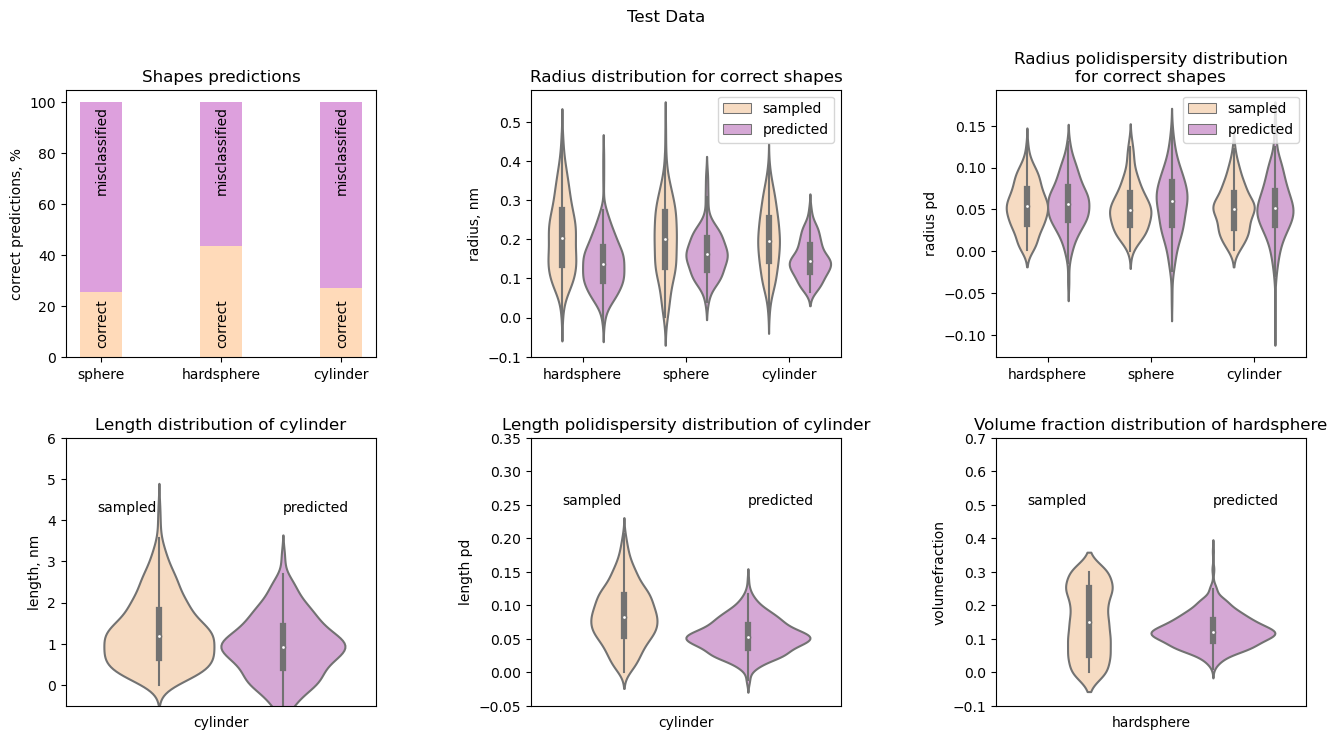

In [16]:
plot_outcomes_identified(df_test, 'Test')

In [29]:
from matplotlib import colors
print(colors.to_hex('peachpuff'),colors.to_hex('plum'))

#ffdab9 #dda0dd


In [17]:
false_shapes = df_test[df_test.true_shape != df_test.pred_shape]

FN_spheres = false_shapes[false_shapes.true_shape == 0]
FP_spheres = false_shapes[false_shapes.pred_shape == 0]
false_spheres = pd.concat([FN_spheres, FP_spheres])

FN_hardspheres = false_shapes[false_shapes.true_shape == 1]
FP_hardspheres = false_shapes[false_shapes.pred_shape == 1]
false_hardspheres = pd.concat([FN_hardspheres, FP_hardspheres])

FN_cylinders = false_shapes[false_shapes.true_shape == 2]
FP_cylinders = false_shapes[false_shapes.pred_shape == 2]
false_cylinders = pd.concat([FN_cylinders, FP_cylinders])

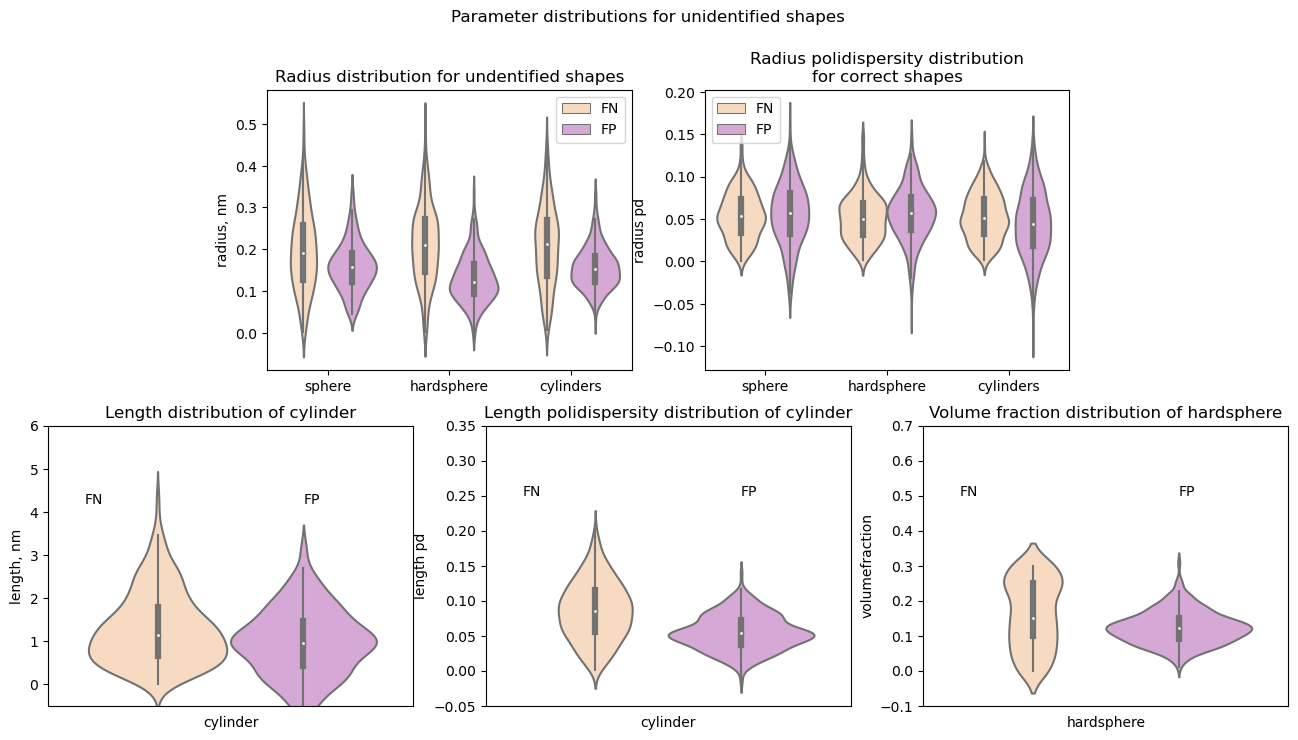

In [18]:
describe_false_shapes(false_spheres, false_hardspheres, false_cylinders)

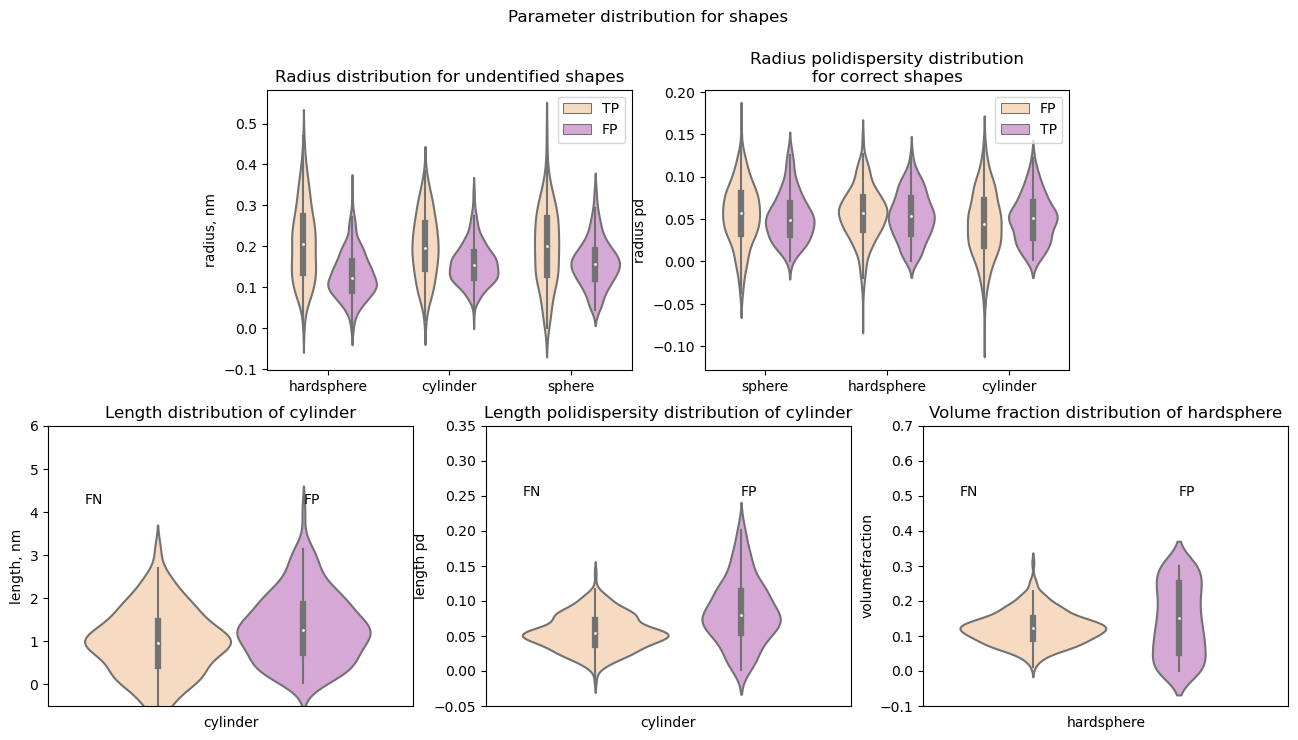

In [19]:
describe_positive_shapes(df_test)

## now look at the unidentified shapes more closely

In [20]:
def assign_class(row):
    if row[0]==1:
        return  'sphere'
    elif row[1] == 1:
        return 'hardsphere'
    elif row[2] == 1:
        return 'cylinder'
shapes_dict = {0:'sphere', 1:'hardsphere', 2:'cylinder'}

In [21]:
prediction_class = pd.DataFrame(make_prediction(labels[test_indices], model)[:,0:3])
prediction_class['true_class'] = pd.DataFrame(inputs[test_indices][:,0:3]).apply(assign_class, axis=1)
prediction_class['prediction'] = prediction_class[[0,1,2]].idxmax(axis=1)
prediction_class.replace({'prediction':shapes_dict}, inplace = True)

In [22]:
unidentified_shapes = prediction_class[prediction_class.true_class != prediction_class.prediction]

In [82]:
# shardpheres id as cylinders <=0.2
temp = unidentified_shapes[(unidentified_shapes.true_class == 'hardsphere')& ((unidentified_shapes[(unidentified_shapes.true_class == 'hardsphere')][[0,1,2]].idxmax(axis=1)!=0) & (np.abs(unidentified_shapes[2] - unidentified_shapes[1])<=0.2))]
print(temp)
len(temp)

             0         1         2  true_class prediction
339  -0.086092  0.548828  0.599264  hardsphere   cylinder
373   0.102340  0.396618  0.439858  hardsphere   cylinder
398   0.302162  0.390269  0.432165  hardsphere   cylinder
429   0.077362  0.412096  0.515531  hardsphere   cylinder
498   0.240697  0.277137  0.356784  hardsphere   cylinder
509  -0.691867  0.798374  0.898354  hardsphere   cylinder
524  -0.144181  0.458457  0.653339  hardsphere   cylinder
533  -0.373256  0.601619  0.754965  hardsphere   cylinder
552  -0.337692  0.551984  0.733326  hardsphere   cylinder
664   0.125115  0.375425  0.480284  hardsphere   cylinder
693  -0.755337  0.906742  1.036391  hardsphere   cylinder
736   0.128645  0.389746  0.443011  hardsphere   cylinder
831   0.261796  0.374870  0.399729  hardsphere   cylinder
968  -0.070287  0.555283  0.578832  hardsphere   cylinder
1073 -0.550803  0.663792  0.850631  hardsphere   cylinder
1078 -0.069094  0.463690  0.563993  hardsphere   cylinder
1089 -0.248133

23

In [83]:
# hardspheres id as spheres <=0.2
temp = unidentified_shapes[(unidentified_shapes.true_class == 'hardsphere')& ((unidentified_shapes[(unidentified_shapes.true_class == 'hardsphere')][[0,1,2]].idxmax(axis=1)!=2) & (np.abs(unidentified_shapes[0] - unidentified_shapes[1])<=0.2))]
print(temp)
len(temp)

             0         1         2  true_class prediction
3     0.439383  0.298828  0.277677  hardsphere     sphere
46    0.529711  0.504904 -0.011106  hardsphere     sphere
49    0.599980  0.509100 -0.047448  hardsphere     sphere
106   0.846592  0.651159 -0.564386  hardsphere     sphere
115   0.686073  0.668014 -0.520852  hardsphere     sphere
132   0.843212  0.656459 -0.512504  hardsphere     sphere
167   0.698941  0.566338 -0.192108  hardsphere     sphere
221   0.502440  0.324362  0.238751  hardsphere     sphere
306   0.943554  0.769532 -0.767628  hardsphere     sphere
399   0.690296  0.682600 -0.461769  hardsphere     sphere
424   0.760801  0.631723 -0.355258  hardsphere     sphere
454   0.538277  0.459670  0.034752  hardsphere     sphere
555   0.626216  0.605245 -0.181987  hardsphere     sphere
710   0.676010  0.513313 -0.218109  hardsphere     sphere
721   0.578417  0.476375 -0.155283  hardsphere     sphere
794   0.541477  0.533165 -0.099998  hardsphere     sphere
812   0.515807

27

In [41]:
len(unidentified_shapes[(unidentified_shapes.true_class == 'hardsphere')]) # unid hs

244

In [84]:
# spheres id as cylinders <=0.2
temp = unidentified_shapes[(unidentified_shapes.true_class == 'sphere')& ((unidentified_shapes[(unidentified_shapes.true_class == 'sphere')][[0,1,2]].idxmax(axis=1)!=1) & (np.abs(unidentified_shapes[2] - unidentified_shapes[0])<=0.2))]
print(temp)
len(temp)

             0         1         2 true_class prediction
90    0.285639  0.217134  0.463491     sphere   cylinder
124   0.380317  0.139480  0.393305     sphere   cylinder
250   0.331935  0.277951  0.463909     sphere   cylinder
407   0.376645  0.199917  0.429073     sphere   cylinder
471   0.347100  0.175050  0.544802     sphere   cylinder
793   0.321262  0.276180  0.383295     sphere   cylinder
915   0.458583  0.053055  0.476173     sphere   cylinder
1015  0.291810  0.371739  0.386820     sphere   cylinder
1041  0.430483 -0.001813  0.500955     sphere   cylinder
1050  0.409396  0.301792  0.426330     sphere   cylinder
1056  0.377672  0.175811  0.441019     sphere   cylinder
1146  0.417042  0.079130  0.436472     sphere   cylinder
1194  0.593233 -0.290595  0.708322     sphere   cylinder
1318  0.376465  0.231582  0.403004     sphere   cylinder
1409  0.346748  0.343144  0.449017     sphere   cylinder
1460  0.374865  0.179329  0.442181     sphere   cylinder


16

In [85]:
# spheres id as hs <=0.2
temp = unidentified_shapes[(unidentified_shapes.true_class == 'sphere')& ((unidentified_shapes[(unidentified_shapes.true_class == 'sphere')][[0,1,2]].idxmax(axis=1)!=2) & (np.abs(unidentified_shapes[1] - unidentified_shapes[0])<=0.2))]
print(temp)
len(temp)

             0         1         2 true_class  prediction
23    0.267363  0.419763  0.286223     sphere  hardsphere
69    0.464031  0.645634 -0.252725     sphere  hardsphere
142   0.495916  0.628257 -0.127594     sphere  hardsphere
170   0.254996  0.442963  0.299609     sphere  hardsphere
258   0.469933  0.532995 -0.111293     sphere  hardsphere
310   0.606813  0.752506 -0.364347     sphere  hardsphere
327   0.280636  0.419249  0.292382     sphere  hardsphere
347   0.501428  0.632012 -0.179370     sphere  hardsphere
440   0.398443  0.460811  0.173377     sphere  hardsphere
478   0.624901  0.774342 -0.341862     sphere  hardsphere
599   0.271810  0.465681  0.263865     sphere  hardsphere
619   0.328973  0.374128  0.256455     sphere  hardsphere
623   0.707621  0.820856 -0.468211     sphere  hardsphere
718   0.378040  0.515083  0.148945     sphere  hardsphere
720   0.839276  1.026678 -0.932129     sphere  hardsphere
764   0.339656  0.455284  0.216107     sphere  hardsphere
922   0.655217

31

In [45]:
len(unidentified_shapes[(unidentified_shapes.true_class == 'sphere')])

380

In [86]:
# cylinders id as hardspheres <=0.2
temp=unidentified_shapes[(unidentified_shapes.true_class == 'cylinder')& ((unidentified_shapes[(unidentified_shapes.true_class == 'cylinder')][[0,1,2]].idxmax(axis=1)!=0) & (np.abs(unidentified_shapes[1] - unidentified_shapes[2])<=0.2))]
print(temp)
len(temp)

             0         1         2 true_class  prediction
134  -0.325556  0.684419  0.638144   cylinder  hardsphere
160   0.233256  0.474888  0.293615   cylinder  hardsphere
166  -0.345024  0.745156  0.671154   cylinder  hardsphere
235   0.038840  0.618178  0.538061   cylinder  hardsphere
363   0.019406  0.564590  0.417501   cylinder  hardsphere
455   0.286733  0.460845  0.368790   cylinder  hardsphere
459  -0.305018  0.772294  0.589600   cylinder  hardsphere
495  -0.282251  0.720271  0.560714   cylinder  hardsphere
500  -0.277392  0.712826  0.575288   cylinder  hardsphere
544  -0.320420  0.697451  0.603544   cylinder  hardsphere
572   0.170169  0.430905  0.321937   cylinder  hardsphere
583  -0.580783  0.765171  0.740844   cylinder  hardsphere
597  -0.201549  0.686328  0.611877   cylinder  hardsphere
616   0.146682  0.464539  0.405669   cylinder  hardsphere
642   0.298099  0.390863  0.366785   cylinder  hardsphere
667  -0.220425  0.725443  0.548333   cylinder  hardsphere
687  -0.037800

37

In [88]:
# cylinders id as spheres <=0.2
temp = unidentified_shapes[(unidentified_shapes.true_class == 'cylinder')& ((unidentified_shapes[(unidentified_shapes.true_class == 'cylinder')][[0,1,2]].idxmax(axis=1)!=1) & (unidentified_shapes[0] - unidentified_shapes[2]<=0.2))]
print(temp)
len(temp)

             0         1         2 true_class prediction
219   0.449970  0.074332  0.420953   cylinder     sphere
226   0.612314  0.102897  0.412562   cylinder     sphere
414   0.469430  0.291676  0.308931   cylinder     sphere
514   0.482599  0.379627  0.291025   cylinder     sphere
553   0.416018  0.268177  0.366853   cylinder     sphere
562   0.406698  0.319356  0.277271   cylinder     sphere
589   0.396090  0.365280  0.252531   cylinder     sphere
617   0.328836  0.325810  0.308559   cylinder     sphere
702   0.603903 -0.059186  0.549158   cylinder     sphere
772   0.591021 -0.042288  0.495311   cylinder     sphere
784   0.389694  0.218917  0.382254   cylinder     sphere
991   0.466187  0.174683  0.365645   cylinder     sphere
1253  0.389174  0.283592  0.193836   cylinder     sphere
1334  0.562969  0.040570  0.532322   cylinder     sphere
1343  0.428561  0.288502  0.278150   cylinder     sphere


15

In [68]:
unidentified_shapes[(unidentified_shapes.true_class == 'cylinder')]

,0,1,2,true_class,prediction
1,-0.093639,0.734339,0.282920,cylinder,hardsphere
2,-0.064136,0.704942,0.364190,cylinder,hardsphere
5,0.422901,0.484562,0.002178,cylinder,hardsphere
7,0.466871,0.698995,-0.300799,cylinder,hardsphere
13,0.445577,0.450158,0.058377,cylinder,hardsphere
...,...,...,...,...,...
1463,-0.020705,0.886492,0.046164,cylinder,hardsphere
1469,0.890959,-0.102228,0.230513,cylinder,sphere
1471,0.746339,0.044175,0.357410,cylinder,sphere
1473,1.263881,-0.097779,-0.175189,cylinder,sphere


In [78]:
#sphere_or_hardsphere
temp = prediction_class[(np.abs(prediction_class[0] - prediction_class[1])<0.4)& (prediction_class[[0,1,2]].idxmax(axis=1)!=2)]
temp.head()

,0,1,2,true_class,prediction
3,0.439383,0.298828,0.277677,hardsphere,sphere
5,0.422901,0.484562,0.002178,cylinder,hardsphere
6,0.544386,0.153092,0.378522,hardsphere,sphere
7,0.466871,0.698995,-0.300799,cylinder,hardsphere
13,0.445577,0.450158,0.058377,cylinder,hardsphere


In [80]:
len(temp[temp.true_class == temp.prediction])/len(temp)

0.3598014888337469

In [24]:
import seaborn as sns

/home/slaskina/.conda/envs/ma/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


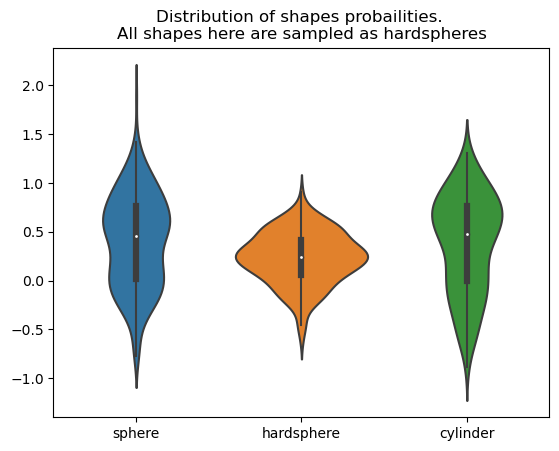

In [25]:
sns.violinplot(unidentified_shapes[unidentified_shapes.true_class == 'hardsphere'][[0,1,2]]);
plt.title('Distribution of shapes probailities. \nAll shapes here are sampled as hardspheres')
plt.xticks([0,1,2], list(shapes_dict.values()));

/home/slaskina/.conda/envs/ma/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


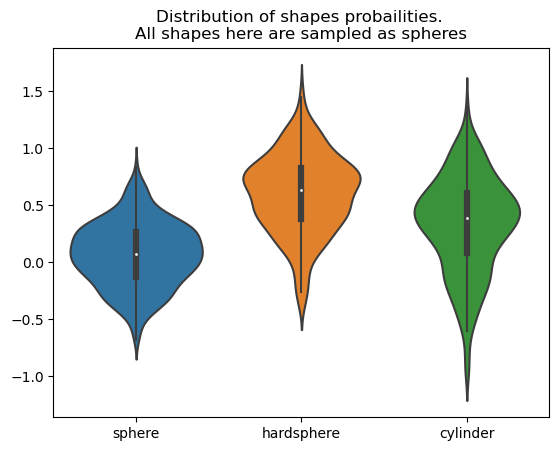

In [26]:
sns.violinplot(unidentified_shapes[unidentified_shapes.true_class == 'sphere'][[0,1,2]]);
plt.title('Distribution of shapes probailities. \nAll shapes here are sampled as spheres')
plt.xticks([0,1,2], list(shapes_dict.values()));

/home/slaskina/.conda/envs/ma/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


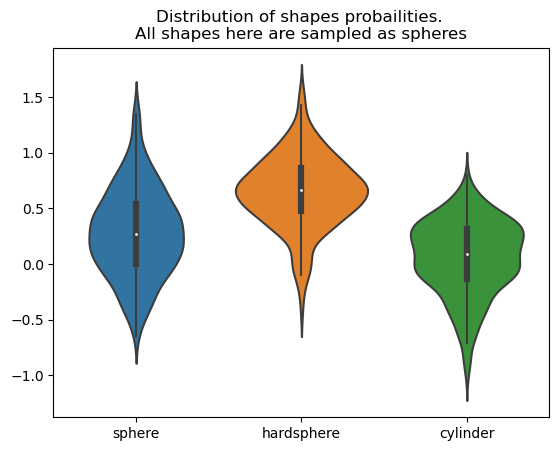

In [27]:
sns.violinplot(unidentified_shapes[unidentified_shapes.true_class == 'cylinder'][[0,1,2]]);
plt.title('Distribution of shapes probailities. \nAll shapes here are sampled as spheres')
plt.xticks([0,1,2], list(shapes_dict.values()));

In [28]:
unidentified_shapes

,0,1,2,true_class,prediction
1,-0.093639,0.734339,0.282920,cylinder,hardsphere
2,-0.064136,0.704942,0.364190,cylinder,hardsphere
3,0.439383,0.298828,0.277677,hardsphere,sphere
5,0.422901,0.484562,0.002178,cylinder,hardsphere
6,0.544386,0.153092,0.378522,hardsphere,sphere
...,...,...,...,...,...
1492,0.302073,1.245099,-0.603291,sphere,hardsphere
1494,-0.312070,0.542958,0.830153,sphere,cylinder
1495,1.187346,0.349619,-0.459046,hardsphere,sphere
1496,-0.044354,1.197583,-0.204117,sphere,hardsphere
